## 1.提取DBC文件信息转为数据域分割的GroundTruth

In [182]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [183]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [184]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('../opendbc-master/opendbc-master-delFalseData')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_can.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_powertrain.dbc',
 'D:\\--storage-

## 2.处理原始bit数据和GroundTruth数据的函数

In [185]:
def get_id_labels(index):
    file_name = file_names[index]
    readFile(file_name)

    # 将DBC文件中的ID(10进制数)改为ID(16进制数)
    data_gts = {}
    for alldata in allDatas:
        data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

    # 得到DBC文件中各ID Message对应信号位置
    all_id_lsbs = {}
    for k in data_gts.keys():
        message = data_gts[k]
        lsb_list = []
        series = np.zeros(64)
        message_id = message[0][0]+"_"+message[0][1]
        del message[0]
        for signal in message:
            start = int(signal[1])
            length = int(signal[2])
            endianness = int(signal[3])
            start_row = int(start / 8)
            start_col = 8 - (start - start_row * 8) - 1
            new_start = start_row * 8 + start_col
            if endianness == 0:
                new_end = new_start + length
                cur_lsb = new_end - 1
            if endianness == 1:
                cur_lsb = new_start
            lsb_list.append(cur_lsb)
        all_id_lsbs[k] = lsb_list

    # 将各ID Message的信号位置改为 0/1 label
    all_id_labels = {}
    for k in all_id_lsbs:
        cur_lsb_list = all_id_lsbs[k]
        cur_label = np.zeros(64)
        for cur_lsb in cur_lsb_list:
            cur_label[cur_lsb] = 1
        all_id_labels[k] = cur_label
    return all_id_lsbs, all_id_labels

In [186]:
def get_trace(data):
    group = data.groupby(by="ID")
    id_tracedict = {}
    for trace in list(group):
        id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).apply(lambda x: list(map(int, x))).tolist()
    return id_tracedict

In [187]:
def get_ids(id_tracedict_int, all_id_labels):
    ids = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            ids.append(id)
    return ids

In [188]:
def get_true_id_tracedict_int(id_tracedict_int, all_id_labels):
    true_id_tracedict_int = []
    for id in id_tracedict_int.keys():
        if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
            true_id_tracedict_int.append(id_tracedict_int[id])
    return true_id_tracedict_int

In [189]:
import random
# 设置全局的随机种子
random.seed(100)
# 以id为单位shuffle
def get_train_test_ids(id_tracedict, all_id_labels):
    ids = get_ids(id_tracedict, all_id_labels)
#     random.shuffle(ids)
    ids.sort()
    train_len = int(len(ids)*0.7)
    train_ids = ids[:train_len]
    test_ids = ids[train_len:]
    return train_ids, test_ids

In [190]:
def get_trace_data_dict(cur_ids, id_tracedict_int, all_id_labels, trace_data_dict, trace_label_dict): 
    for id in cur_ids:
        trace_data_dict[id] = id_tracedict_int[id]
        trace_label_dict[id] = all_id_labels[id]

In [191]:
def rpad_0(cur_str, width):
    pad_len = width - len(cur_str)
    for i in range(pad_len):
        cur_str = cur_str + '0'
    return cur_str

## 3.综合Honda和Cadillac数据，得到训练集和测试集（包括0/1Label）

**在ID层面Shuffle**

In [192]:
# 合并所有Cadillac以及Chevy车的Ground Truth的 0/1 label
all_id_lsbs0, dict0 = get_id_labels(0)
all_id_lsbs1, dict1 = get_id_labels(1)
all_id_lsbs2, dict2 = get_id_labels(2)
cadillac_id_labels = dict()
for key in dict0.keys() | dict1.keys() | dict2.keys():
    for d in (dict0, dict1, dict2):
        if d.__contains__(key):
            cadillac_id_labels[key] = d[key]
            break
cadillac_id_lsb = dict()
for key in all_id_lsbs0.keys() | all_id_lsbs1.keys() | all_id_lsbs2.keys():
    for d in (all_id_lsbs0, all_id_lsbs1, all_id_lsbs2):
        if d.__contains__(key):
            cadillac_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_object.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\cadillac_ct6_powertrain.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\gm_global_a_powertrain.dbc


In [193]:
# 合并所有Honda车的Ground Truth的 0/1 label
all_id_lsbs3, dict3 = get_id_labels(3)
all_id_lsbs4, dict4 = get_id_labels(4)
all_id_lsbs5, dict5 = get_id_labels(5)
honda_id_labels = dict()
for key in dict3.keys() | dict4.keys() | dict5.keys():
    for d in (dict3, dict4, dict5):
        if d.__contains__(key):
            honda_id_labels[key] = d[key]
            break
honda_id_lsb = dict()
for key in all_id_lsbs3.keys() | all_id_lsbs4.keys() | all_id_lsbs5.keys():
    for d in (all_id_lsbs3, all_id_lsbs4, all_id_lsbs5):
        if d.__contains__(key):
            honda_id_lsb[key] = d[key]
            break

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_sedan_16_diesel_2019_can_generated.dbc
D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_touring_2016_can_generated.dbc


In [194]:
oct2bin = {"0":"0000","1":"0001","2":"0010","3":"0011","4":"0100","5":"0101","6":"0110","7":"0111","8":"1000","9":"1001",
           "a":"1010","b":"1011","c":"1100","d":"1101","e":"1110","f":"1111"}

In [195]:
def hex2bin(cur_hex):
    res = ""
    for i in cur_hex:
        res = res + oct2bin[i]
    res = rpad_0(res,64)
    return res

In [196]:
# 得到Honda车的子数据集数据
data_hd_1 = pd.read_csv('../Data/Honda/honda001.csv')
data_hd_2 = pd.read_csv('../Data/Honda/honda002.csv')
# data_hd_2 = pd.read_csv('../Data/Honda/honda003.csv')
data_hd = pd.concat([data_hd_1,data_hd_2])
# data_hd = pd.read_csv('../Data/Honda/honda001.csv')

In [197]:
data_hd["bin"] = data_hd["Data"].apply(lambda x: hex2bin(x))

In [96]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_hd = get_trace(data_hd)
# id_tracedict_hd = get_true_id_tracedict_int(id_tracedict_hd, honda_id_labels)
# 得到用于训练和测试的id
train_ids_hd, test_ids_hd = get_train_test_ids(id_tracedict_hd, honda_id_labels)  

In [97]:
# 得到Cadillac车的子数据集数据
data_cd_1 = pd.read_csv('../Data/Cadillac/CadillacCSV/001.txt.csv')
data_cd_2 = pd.read_csv('../Data/Cadillac/CadillacCSV/002.txt.csv')
data_cd = pd.concat([data_cd_1,data_cd_2])
# data_cd = pd.read_csv('../Data/Cadillac/CadillacCSV/001.txt.csv')

In [98]:
data_cd["bin"] = data_cd["Data"].apply(lambda x: hex2bin(x))

In [100]:
# 得到Honda车子的数据集的大Trace dict
id_tracedict_cd = get_trace(data_cd)
# 得到用于训练和测试的id
train_ids_cd, test_ids_cd = get_train_test_ids(id_tracedict_cd, cadillac_id_labels)

In [101]:
# 得到honda和caddilac车的trace dict及对应的label dict
train_data_dict = {}
train_label_dict = {}
get_trace_data_dict(train_ids_hd, id_tracedict_hd, honda_id_labels, train_data_dict, train_label_dict)
get_trace_data_dict(train_ids_cd, id_tracedict_cd, cadillac_id_labels, train_data_dict, train_label_dict)

test_data_dict = {}
test_label_dict = {}
get_trace_data_dict(test_ids_hd, id_tracedict_hd, honda_id_labels, test_data_dict, test_label_dict)
get_trace_data_dict(test_ids_cd, id_tracedict_cd, cadillac_id_labels, test_data_dict, test_label_dict)

In [102]:
def get_trace_data(id_tracedict_int, all_id_labels): 
    cur_trace_data = []
    cur_trace_label = []
    for id in id_tracedict_int.keys():
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            cur_trace_data.append(cur_trace[start: end])
            cur_trace_label.append(cur_label)
            start = end
            end = start + 1000
    return cur_trace_data, cur_trace_label

In [103]:
def get_data_label(id_tracedict_int, all_id_labels):
    cur_trace_data, cur_trace_label = get_trace_data(id_tracedict_int, all_id_labels)
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

In [ ]:
# 使用READ方法计算bit-flip
def get_bit_Flips(cur_id_traces):
    bit_Flips = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
        bit_flip = np.append(bit_flip, 0)
        bit_flip = np.append(bit_flip, 0)
        bit_Flips.append(bit_flip)
    return bit_Flips

In [104]:
train_data, train_labels = get_data_label(train_data_dict, train_label_dict)
test_data, test_labels = get_data_label(test_data_dict, test_label_dict)

In [181]:
def clear_data_labels(train_data,train_labels):
    new_train_data = []
    new_train_labels = []
    bit_Flips = get_bit_Flips(train_data)
    for i in range(len(bit_Flips)):
        if sum(bit_Flips[i]) != 0:
            new_train_data.append(train_data[i])
            new_train_labels.append(train_labels[i])
    return new_train_data, new_train_labels

In [ ]:
train_data, train_labels = clear_data_labels(train_data,train_labels)
test_data, test_labels = clear_data_labels(test_data,test_labels)

## DL Model

In [106]:
import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D,Conv2D, MaxPooling2D
from keras.layers import concatenate, add
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
from sklearn import metrics
from keras.callbacks import Callback
from keras.models import load_model
from keras.optimizers import Adam

In [ ]:
#### 之后需要加深Conv，增加maxpooling

In [179]:
# inputs = Input(shape = (1000,64,1))
# x = keras.layers.Conv2D(15, 3, padding='same', data_format='channels_last')(inputs)
# # x = layers.Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(x)
# x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
# outputs = Dense(64, activation='sigmoid')(x)
# model = Model(inputs=inputs, outputs=outputs)
# # keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# keras.optimizers.Adam(lr=1e-3)
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
# # model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[my_acc])
# model.summary()

In [ ]:
inputs = Input(shape = (1000,64,1))
x = Conv2D(15, (3,3), padding='same', data_format='channels_last')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=3, padding='valid')(x)
x = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=3, padding='valid')(x)
x = Conv2D(15, (3,3), padding='same', data_format='channels_last')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(64, activation='sigmoid')(x)
keras.optimizers.Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

In [150]:
train_data_4 = np.expand_dims(train_data, 3)
test_data_4 = np.expand_dims(test_data, 3)

In [151]:
mytrain_data = train_data_4
mytrain_labels = train_labels

mytest_data = test_data_4
mytest_labels = test_labels

In [152]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='./Model/My_model/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
    monitor='acc',
    factor=0.2,
    patience=2,
    )
]

history = model.fit(mytrain_data, mytrain_labels,
     epochs=5,
     batch_size=10,
     callbacks=callbacks_list
#      validation_split=0.1
#      validation_data=(myval_data, myval_labels)
    )

Epoch 1/5
1719/1719 [==============================] - 157s 91ms/step - loss: 1.2289 - acc: 0.9132
Epoch 2/5


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\keras\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1719/1719 [==============================] - 136s 79ms/step - loss: 0.5198 - acc: 0.9662
Epoch 3/5
1719/1719 [==============================] - 142s 83ms/step - loss: 0.4299 - acc: 0.9717
Epoch 4/5
1719/1719 [==============================] - 131s 76ms/step - loss: 0.4021 - acc: 0.9745
Epoch 5/5
1719/1719 [==============================] - 130s 76ms/step - loss: 0.3981 - acc: 0.9750


In [153]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

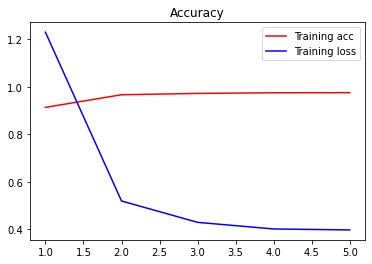

In [154]:
plt.title('Accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.legend()
plt.show()

In [155]:
print("训练集:")
predict_target_msb_prob = model.predict(mytrain_data)
predict_target_msb_label = (predict_target_msb_prob > 0.5).astype(int)
predict_target_msb_1D = predict_target_msb_label.flatten()
train_labels_1D = mytrain_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_1D == train_labels_1D),len(train_labels_1D))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels_1D,predict_target_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels_1D,predict_target_msb_1D))

训练集:
预测正确数量,训练集样本量:
107314 110016
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    101298
         1.0       0.97      0.71      0.82      8718

    accuracy                           0.98    110016
   macro avg       0.97      0.85      0.90    110016
weighted avg       0.98      0.98      0.97    110016

混淆矩阵：
[[101131    167]
 [  2535   6183]]


In [156]:
print("测试集:")
predict_target_test_msb_prob =model.predict(mytest_data)
predict_target_test_msb_label = (predict_target_test_msb_prob > 0.5).astype(int)
predict_target_test_msb_1D = predict_target_test_msb_label.flatten()
test_labels_1D = mytest_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,predict_target_test_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,predict_target_test_msb_1D))

测试集:
预测正确数量,训练集样本量:
24342 26112
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     25230
         1.0       0.14      0.19      0.16       882

    accuracy                           0.93     26112
   macro avg       0.55      0.57      0.56     26112
weighted avg       0.94      0.93      0.94     26112

混淆矩阵：
[[24177  1053]
 [  717   165]]


## READ

In [36]:
# 使用READ方法计算bit-flip
import math
inf = -11
def get_preparation(trace_data):
    bit_Flips = []
    Magnitudes = []
    for i in range(len(trace_data)):
        messagelist = trace_data[i]
        trace_len = len(messagelist)
        bit_flip = np.zeros(64)
        magnitude = np.zeros(64)
        previous = messagelist[0]
        for item in messagelist:
            for ix in range(64):
                if item[ix] != previous[ix]:
                    bit_flip[ix] = bit_flip[ix] + 1
            previous = item
        for ix in range(64):
            bit_flip[ix] = bit_flip[ix] / trace_len
            if bit_flip[ix] == 0:
                cur_magnitude = inf
            else:
                cur_magnitude = math.log10(bit_flip[ix])
            magnitude[ix] = math.ceil(cur_magnitude)
        bit_Flips.append(bit_flip)
        Magnitudes.append(magnitude)
    return bit_Flips, Magnitudes

In [38]:
def get_phase1(magnitude):
    ref = []
    prevMagnitude = magnitude[0]
    ixS = 0
    for ix in range(64):
        if magnitude[ix] < prevMagnitude:
            ref.append((ixS, ix-1))
            ixS = ix
        prevMagnitude = magnitude[ix]
    ref.append((ixS, 63))
    return ref

In [39]:
def matchCounter(sublist):
    if(sublist[-1] != 1):
        return -1
    ixS = len(sublist)-1
    for i in range(len(sublist)-2,-1,-1):
        if sublist[i] == (sublist[i+1] / 2):
            ixS = i
    return ixS

In [40]:
def get_phase2(ref, bit_flip, magnitude):
    rRef = []
    for sign in ref:
        (ixS, ixE) = sign
        mgt = magnitude[ixS: ixE+1]
        mu = np.mean(bit_flip[ixS: ixE+1])
        std = np.std(bit_flip[ixS: ixE+1])
        if magnitude[ixE] == 0:
            Sctr = matchCounter(bit_flip[ixS: ixE+1])
#             print(Sctr)
            if Sctr >= 0:
                rRef.append((ixS, Sctr, "PHYSVAL"))
                rRef.append((Sctr, ixE, "COUNTER"))
        else:
            exit = False
            for Scrc in range(ixS, ixE+1):
                if not exit:
#                     print(Scrc)
                    if sum(magnitude[Scrc: (ixE+1)]) == 0 and mu >= (0.5-std) and mu <= (0.5+std):
                        rRef.append((Scrc, ixE, "CRC"))
                        rRef.append((ixS, Scrc, "PHYSVAL"))
                        exit = True
                else:
                    break
    return rRef

In [41]:
def position2preds(preds_ref):
    preds = []
    for i in range(len(preds_ref)):
        cur_ref = preds_ref[i]
        cur_preds = np.zeros(64)
        for signal in cur_ref:
            cur_preds[signal[1]] = 1
        preds.append(cur_preds)
    return np.array(preds)

In [42]:
def get_boundary_score(y_true, y_pred):
    new_labels = []
    new_preds = []
    for i in range(len(y_true)):
        if(y_true[i] == 1):
            new_labels.append(y_true[i])
            new_preds.append(y_pred[i])
    return np.array(new_labels), np.array(new_preds)

In [163]:
fasle_i = [7 ,8 ,11 ,12 ,14 ,15 ,16 ,17]
false_id = []
for i in fasle_i:
    false_id.append(list(test_data_dict.keys())[i])

In [164]:
origin_trace = []
origin_label = []
for id in test_data_dict.keys():
    if id not in false_id:
        origin_trace.append(test_data_dict[id])
        origin_label.append(test_label_dict[id])
origin_trace = np.array(origin_trace)
origin_label = np.array(origin_label)

In [165]:
test_data_dict.keys()

dict_keys(['305', '309', '324', '374', '405', '4d1', '4d4', '4e1', '514', '52a', '52b', '530', '541', '641', '778', '787', 'be', 'c9', 'd1', 'f1'])

In [167]:
# test_ids_cd

In [168]:
# test_ids_hd

In [169]:
READ_test_data = origin_trace
READ_test_labels = origin_label

# READ_test_data = test_data
# READ_test_labels = test_labels

# READ_test_data = np.array(cur_data)
# READ_test_labels =  np.array(cur_label)

In [170]:
bit_flip_dict, magnitude_dict = get_preparation(READ_test_data)
preds_ref = []
preds_rRef = []
for i in range(len(magnitude_dict)):
    ref = get_phase1(magnitude_dict[i])
    rRef = get_phase2(ref, bit_flip_dict[i], magnitude_dict[i])
    preds_rRef.append(rRef)
    preds_ref.append(ref)
preds = position2preds(preds_ref)

In [171]:
# READ_test_labels[1]

In [174]:
len(bit_flip_dict)

12

In [175]:
# plt.bar(np.arange(64), bit_flip_dict[],label="bit-flip")
# # plt.bar(np.arange(64), READ_test_labels[10],label="label",color="black")
# plt.legend()

In [176]:
# plt.bar(np.arange(64), bit_flip_dict[3],label="bit-flip")
# plt.bar(np.arange(64), preds[3],label="preds")
# plt.legend()

In [177]:
# plt.bar(np.arange(64), magnitude_dict[1],label="magnitude")

In [178]:
from sklearn import metrics
print("测试集:")
preds_msb_1D = preds.flatten()
test_labels_1D = READ_test_labels.flatten()
print("预测正确数量,训练集样本量:")
print(sum(preds_msb_1D == test_labels_1D),len(test_labels_1D))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels_1D,preds_msb_1D))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels_1D,preds_msb_1D))

测试集:
预测正确数量,训练集样本量:
667 768
测试集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       678
         1.0       0.42      0.34      0.38        90

    accuracy                           0.87       768
   macro avg       0.67      0.64      0.65       768
weighted avg       0.86      0.87      0.86       768

混淆矩阵：
[[636  42]
 [ 59  31]]


## 4.CAN-D数据特征提取函数

In [223]:
def del_constant_bit(cur_trace_data, cur_trace_label, bit_Flips):
    for i in range(len(bit_Flips)):
        cur_bit_flip = bit_Flips[i]
        cur_constant_bits = []
        for j in range(64):
            if cur_bit_flip[j] == 0:
                cur_constant_bits.append(j)
        a = cur_trace_data[i]
        b = []
        for temp in a:
            b.append([temp[j] for j in range(len(temp)) if j not in cur_constant_bits])
        cur_trace_data[i] = b
        temp = []
        for j in range(len(cur_trace_label[i])):
            next_j = j+1
            if j not in cur_constant_bits:
                if next_j in cur_constant_bits:
                    temp.append(1)
                else:
                    temp.append(cur_trace_label[i][j])
        cur_trace_label[i] = temp
#         cur_trace_label[i] = [temp[j] for j in range(len(temp)) if j not in cur_constant_bits]
        temp = bit_Flips[i]
        bit_Flips[i] = [temp[j] for j in range(len(temp)) if j not in cur_constant_bits]
    return cur_trace_data, cur_trace_label, bit_Flips

In [224]:
# 使用READ方法计算bit-flip的联合概率
def get_bit_Flip_LHs(cur_id_traces):
    bit_Flip_LHs = []
    bit_Flip_LH_nos = []
    for i in range(len(cur_id_traces)):
        messagelist = cur_id_traces[i]
        trace_len = len(messagelist)
        message_len = len(messagelist[0])
        bit_flip_LH = np.zeros(message_len)
        bit_flip_LH_no = np.zeros(message_len)
        previous_LH = messagelist[0]
        for item in messagelist:
            for ix in range(message_len-1):
                if item[ix] != previous_LH[ix] and item[ix+1] != previous_LH[ix+1]:
                    bit_flip_LH[ix] = bit_flip_LH[ix] + 1
                if item[ix] == previous_LH[ix] and item[ix+1] == previous_LH[ix+1]:
                    bit_flip_LH_no[ix] = bit_flip_LH_no[ix] + 1
            previous_LH = item
        for ix in range(message_len-1):
            bit_flip_LH[ix] = bit_flip_LH[ix] / trace_len
            bit_flip_LH_no[ix] = bit_flip_LH_no[ix] / trace_len

        bit_flip_LH = np.append(bit_flip_LH, 0)
        bit_flip_LH = np.append(bit_flip_LH, 0)
        bit_flip_LH_no = np.append(bit_flip_LH_no, 0)
        bit_flip_LH_no = np.append(bit_flip_LH_no, 0)

        bit_Flip_LHs.append(bit_flip_LH)
        bit_Flip_LH_nos.append(bit_flip_LH_no)
    return bit_Flip_LHs, bit_Flip_LH_nos

In [225]:
# reverse_id_tracelist 通过大端bit序列得到小端bit序列
def get_reverse_id_traces(cur_id_traces):
    reverse_id_traces = []
    for i in range(len(cur_id_traces)):
        id_tracelist = cur_id_traces[i]
        reverse_id_tracelist = []
        for item in id_tracelist:
            cur_tracelist = [0,1,2,3,4,5,6,7]
            cur_temp = []
            count = 7
            for i in range(64):
                cur_temp.append(item[i])
                if (i+1)%8 == 0:
                    cur_tracelist[count] = cur_temp
                    count = count - 1
                    cur_temp = []
            reverse_id_tracelist.append(np.concatenate(cur_tracelist).tolist())
        reverse_id_traces[i] = reverse_id_tracelist
    return reverse_id_traces

In [226]:
# 得到每个bit的15个特征
def get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i):
    f1 = bit_Flips[i][ix]
#     print(bit_Flips[i], i, ix)
    f2 = bit_Flips_LH[i][ix] / bit_Flips[i][ix+1]
    f3 = bit_Flips_LH[i][ix] / bit_Flips[i][ix]
    f4 = bit_Flip_LH_nos[i][ix] / (1 - bit_Flips[i][ix+1])
    f5 = bit_Flip_LH_nos[i][ix] / (1 - bit_Flips[i][ix])
    return np.array([f1,f2,f3,f4,f5])

def get_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i):
    cur_bit_feature = []
    feature_sub1 = get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i)
    feature_sub2 = get_sub_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix+1, i)
    feature_sub3 = feature_sub2 - feature_sub1
    return np.concatenate((feature_sub1,feature_sub2,feature_sub3))

In [227]:
# 为每个bit赋予15个特征
def get_bit_features_list(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos):
    bit_features_list = []
    for i in range(len(bit_Flips)):
        bit_features = []
        for ix in range(len(bit_Flips[i])-2):
            bit_features.append(get_feature(bit_Flips, bit_Flips_LH, bit_Flip_LH_nos, ix, i))
        bit_features_list.append(bit_features)
    return bit_features_list

In [228]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
def LE_to_BE(reverse_bit_features_list):
    bit_features_list = []
    for i in range(len(reverse_bit_features_list)):
        item = reverse_bit_features_dict[i]
        cur_bit_features = [0,1,2,3,4,5,6,7]
        cur_temp = []
        count = 7
        for i in range(64):
            cur_temp.append(item[i])
            if (i+1)%8 == 0:
                cur_bit_features[count] = cur_temp
                count = count - 1
                cur_temp = []
        bit_features_list.append(np.concatenate(cur_bit_features).tolist())
    return bit_features_list

In [229]:
# 得到Trace与Ground Truth都存在的id
def get_all_datas_labels(bit_features_list, cur_id_labels):
    alldatas = []
    alllabels = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for i in range(len(cur_features)):
            alldatas.append(cur_features[i])
            alllabels.append(int(cur_labels[i]))
    return alldatas, alllabels

In [230]:
def get_shuffle_data_label(cur_trace_data, cur_trace_label):
    trace_indexs = pd.DataFrame(cur_trace_label).index.tolist()
    random.shuffle(trace_indexs)
    trace_data, trace_labels = np.array(cur_trace_data)[trace_indexs], np.array(cur_trace_label)[trace_indexs]
    return trace_data, trace_labels

## 5.训练大端的RF模型，去掉constant bit

### 预训练模型

In [231]:
train_id_traces, train_id_labels = get_trace_data(train_data_dict, train_label_dict)
bit_Flips_train = get_bit_Flips(train_id_traces)
train_id_traces, train_id_labels, bit_Flips_train = del_constant_bit(train_id_traces, train_id_labels, bit_Flips_train)
bit_Flip_LHs_train, bit_Flip_LH_nos_train = get_bit_Flip_LHs(train_id_traces)
bit_features_list_train = get_bit_features_list(bit_Flips_train, bit_Flip_LHs_train, bit_Flip_LH_nos_train)
traindatas_msb, trainlabels_msb = get_all_datas_labels(bit_features_list_train, train_id_labels)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [232]:
test_id_traces, test_id_labels = get_trace_data(test_data_dict, test_label_dict)
bit_Flips_test = get_bit_Flips(test_id_traces)
test_id_traces, test_id_labels, bit_Flips_test = del_constant_bit(test_id_traces, test_id_labels, bit_Flips_test)
bit_Flip_LHs_test, bit_Flip_LH_nos_test = get_bit_Flip_LHs(test_id_traces)
bit_features_list_test = get_bit_features_list(bit_Flips_test, bit_Flip_LHs_test, bit_Flip_LH_nos_test)
testdatas_msb, testlabels_msb = get_all_datas_labels(bit_features_list_test, test_id_labels)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [242]:
traindatas_msb, trainlabels_msb = get_shuffle_data_label(traindatas_msb, trainlabels_msb)
testdatas_msb, testlabels_msb = get_shuffle_data_label(testdatas_msb, testlabels_msb)

In [243]:
Traindata_msb = pd.DataFrame(traindatas_msb)
Traindata_msb['label'] = np.array(trainlabels_msb)
Traindata_msb = Traindata_msb.fillna(0)
traindatas_msb = np.array(Traindata_msb.iloc[:,:15])
trainlabels_msb = np.array(Traindata_msb.iloc[:,-1])

In [244]:
Testdata_msb = pd.DataFrame(testdatas_msb)
Testdata_msb['label'] = np.array(testlabels_msb)
Testdata_msb = Testdata_msb.fillna(0)
testdatas_msb = np.array(Testdata_msb.iloc[:,:15])
testlabels_msb = np.array(Testdata_msb.iloc[:,-1])

In [245]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_msb = RandomForestClassifier(n_estimators= 30)
model_msb.fit(traindatas_msb, trainlabels_msb)

print("训练集:")
predict_target_msb = model_msb.predict(traindatas_msb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb == trainlabels_msb),len(trainlabels_msb))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_msb,predict_target_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb,predict_target_msb))

print("测试集:")
predict_target_test_msb =model_msb.predict(testdatas_msb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb == testlabels_msb),len(testlabels_msb))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_msb,predict_target_test_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb,predict_target_test_msb))

训练集:
预测正确数量,训练集样本量:
40919 41188
训练集精确度等指标：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34887
           1       0.98      0.97      0.98      6301

    accuracy                           0.99     41188
   macro avg       0.99      0.99      0.99     41188
weighted avg       0.99      0.99      0.99     41188

混淆矩阵：
[[34787   100]
 [  169  6132]]
测试集:
预测正确数量,训练集样本量:
8094 8977
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7403
           1       0.71      0.73      0.72      1574

    accuracy                           0.90      8977
   macro avg       0.83      0.83      0.83      8977
weighted avg       0.90      0.90      0.90      8977

混淆矩阵：
[[6944  459]
 [ 424 1150]]


### 微调模型

In [246]:
train_id_traces_f, train_id_labels_f = get_trace_data(train_data_dict, train_label_dict)
bit_Flips_train_f = get_bit_Flips(train_id_traces_f)
bit_Flip_LHs_train_f, bit_Flip_LH_nos_train_f = get_bit_Flip_LHs(train_id_traces_f)
bit_features_list_train_f = get_bit_features_list(bit_Flips_train_f, bit_Flip_LHs_train_f, bit_Flip_LH_nos_train_f)
traindatas_msb_f, trainlabels_msb_f = get_all_datas_labels(bit_features_list_train_f, train_id_labels_f)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [247]:
test_id_traces_f, test_id_labels_f = get_trace_data(test_data_dict, test_label_dict)
bit_Flips_test_f = get_bit_Flips(test_id_traces_f)
bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f = get_bit_Flip_LHs(test_id_traces_f)
bit_features_list_test_f = get_bit_features_list(bit_Flips_test_f, bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f)
testdatas_msb_f, testlabels_msb_f = get_all_datas_labels(bit_features_list_test_f, test_id_labels_f)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [248]:
traindatas_msb_f, trainlabels_msb_f = get_shuffle_data_label(traindatas_msb_f, trainlabels_msb_f)
testdatas_msb_f, testlabels_msb_f = get_shuffle_data_label(testdatas_msb_f, testlabels_msb_f)

Traindata_msb_f = pd.DataFrame(traindatas_msb_f)
Traindata_msb_f['label'] = np.array(trainlabels_msb_f)
Traindata_msb_f = Traindata_msb_f.fillna(0)
traindatas_msb_f = np.array(Traindata_msb_f.iloc[:,:15])
trainlabels_msb_f = np.array(Traindata_msb_f.iloc[:,-1])

Testdata_msb_f = pd.DataFrame(testdatas_msb_f)
Testdata_msb_f['label'] = np.array(testlabels_msb_f)
Testdata_msb_f = Testdata_msb_f.fillna(0)
testdatas_msb_f = np.array(Testdata_msb_f.iloc[:,:15])
testlabels_msb_f = np.array(Testdata_msb_f.iloc[:,-1])

In [249]:
np.array(train_id_traces_f).shape

(1719, 1000, 64)

In [250]:
def is_nonobvious_boundary(cur_features, j):
    if j == 0:
        if cur_features[1][0] != 0:
            return True
        else:
            return False
    if j == 63:
        if cur_features[62][0] != 0:
            return True
        else:
            return False
#     print(j, len(cur_features))
    if cur_features[j-1][0] != 0 and cur_features[j+1][0] != 0:
        return True
    return False

In [251]:
def get_tun_data_label(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    obvious_boundaries = []
    obvious_boundaries_label = []
    negative_bit = []
    negativ_bit_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 0:
                negative_bit.append(cur_features[j])
                negativ_bit_label.append(int(cur_labels[j]))
            elif is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
            else:
                obvious_boundaries.append(cur_features[j])
                obvious_boundaries_label.append(int(cur_labels[j]))

    len_nb = len(nonobvious_boundaries_label)
    len_ne = int(len_nb/8 * 4)
    len_ob = int(len_nb/8)
    train_data = np.concatenate([nonobvious_boundaries, negative_bit[:len_ne], obvious_boundaries[:len_ob]])
    train_label = np.concatenate([nonobvious_boundaries_label, negativ_bit_label[:len_ne], obvious_boundaries_label[:len_ob]])
    tun_data, tun_label = get_shuffle_data_label(train_data, train_label)
    return tun_data, tun_label

In [252]:
def get_test_data_label(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 1 and is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
    test_data, test_label = get_shuffle_data_label(nonobvious_boundaries, nonobvious_boundaries_label)
    return test_data, test_label

In [253]:
def get_data_label_boundary(bit_features_list, cur_id_labels):
    boundaries = []
    boundaries_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 1:
                boundaries.append(cur_features[j])
                boundaries_label.append(int(cur_labels[j]))
    test_data, test_label = get_shuffle_data_label(boundaries, boundaries_label)
    return test_data, test_label

In [254]:
def get_data_label_boundary_constant(bit_features_list, cur_id_labels):
    nonobvious_boundaries = []
    nonobvious_boundaries_label = []
    negative_bit = []
    negativ_bit_label = []
    for i in range(len(bit_features_list)):
        cur_features = bit_features_list[i]
        cur_labels = cur_id_labels[i]
        for j in range(len(cur_features)):
            if cur_labels[j] == 0:
                negative_bit.append(cur_features[j])
                negativ_bit_label.append(int(cur_labels[j]))
            elif is_nonobvious_boundary(cur_features, j):
                nonobvious_boundaries.append(cur_features[j])
                nonobvious_boundaries_label.append(int(cur_labels[j]))
    train_data = np.concatenate([nonobvious_boundaries, negative_bit])
    train_label = np.concatenate([nonobvious_boundaries_label, negativ_bit_label])
    tun_data, tun_label = get_shuffle_data_label(train_data, train_label)
    return tun_data, tun_label

In [257]:
tun_data, tun_label = get_tun_data_label(bit_features_list_train_f, train_id_labels_f)

Traindata_msb_f = pd.DataFrame(tun_data)
Traindata_msb_f['label'] = np.array(tun_label)
Traindata_msb_f = Traindata_msb_f.fillna(0)
tun_data = np.array(Traindata_msb_f.iloc[:,:15])
tun_label = np.array(Traindata_msb_f.iloc[:,-1])

In [65]:
tun_data_2, tun_label_2 = get_tun_data_label(bit_features_list_test_f, test_id_labels_f)

Traindata_msb_f = pd.DataFrame(tun_data_2)
Traindata_msb_f['label'] = np.array(tun_label_2)
Traindata_msb_f = Traindata_msb_f.fillna(0)
tun_data_2 = np.array(Traindata_msb_f.iloc[:,:15])
tun_label_2 = np.array(Traindata_msb_f.iloc[:,-1])

In [52]:
tun_test_data, tun_test_label = get_test_data_label(bit_features_list_test_f, test_id_labels_f)

Testdata_msb_f = pd.DataFrame(tun_test_data)
Testdata_msb_f['label'] = np.array(tun_test_label)
Testdata_msb_f = Testdata_msb_f.fillna(0)
tun_test_data = np.array(Testdata_msb_f.iloc[:,:15])
tun_test_label = np.array(Testdata_msb_f.iloc[:,-1])

In [70]:
bit_features_list_f = np.concatenate([bit_features_list_train_f,bit_features_list_test_f])
id_labels_f = np.concatenate([train_id_labels_f,test_id_labels_f])

tun_test_data_all, tun_test_label_all = get_test_data_label(bit_features_list_f, id_labels_f)

Testdata_msb_f = pd.DataFrame(tun_test_data_all)
Testdata_msb_f['label'] = np.array(tun_test_label_all)
Testdata_msb_f = Testdata_msb_f.fillna(0)
tun_test_data_all = np.array(Testdata_msb_f.iloc[:,:15])
tun_test_label_all = np.array(Testdata_msb_f.iloc[:,-1])

In [75]:
bit_features_list_f = np.concatenate([bit_features_list_train_f,bit_features_list_test_f])
id_labels_f = np.concatenate([train_id_labels_f,test_id_labels_f])

tun_test_data_boundary, tun_test_label_boundary = get_data_label_boundary(bit_features_list_f, id_labels_f)

Testdata_msb_f = pd.DataFrame(tun_test_data_boundary)
Testdata_msb_f['label'] = np.array(tun_test_label_boundary)
Testdata_msb_f = Testdata_msb_f.fillna(0)
tun_test_data_boundary = np.array(Testdata_msb_f.iloc[:,:15])
tun_test_label_boundary = np.array(Testdata_msb_f.iloc[:,-1])

In [255]:
f1_data, f1_label = get_data_label_boundary_constant(bit_features_list_train_f, train_id_labels_f)

Traindata_msb_f = pd.DataFrame(f1_data)
Traindata_msb_f['label'] = np.array(f1_label)
Traindata_msb_f = Traindata_msb_f.fillna(0)
f1_data = np.array(Traindata_msb_f.iloc[:,:15])
f1_label = np.array(Traindata_msb_f.iloc[:,-1])

In [258]:
param_distribution = [
    {'n_estimators' : [30, 60, 90,150,200,250], 'max_features' : [2, 4, 6, 8,10], 
     'max_depth':[1,2,3,4,5,6],'min_samples_leaf':[1,2,3,4]},
#     {'bootstrap' : [False], 'n_estimators' : [3, 10], 'max_features' : [2, 3, 4]},
]
 
from sklearn.model_selection import RandomizedSearchCV
# from scikitlearn.scikit_learn.sklearn.model_selection._search import RandomizedSearchCV
 
random_search_cv = RandomizedSearchCV(model_msb,
                                      param_distribution,
                                      n_iter = 30,#从param_distribution里sample出多少个参数集合
                                      cv = 10,
                                      scoring='neg_mean_squared_error',
#                                       scoring=my_scores,
                                      n_jobs = 1) #有多少任务并行处理
# random_search_cv.fit(traindatas_msb_f, trainlabels_msb_f)
random_search_cv.fit(tun_data, tun_label)
 
# 在超参数搜索时有cross_validation机制: 训练集分成n份，n-1训练，最后一份验证.
# 在超参数搜索完之后，会在全部训练集上用新的参数再训练一遍
 
print(random_search_cv.best_params_) #最好参数
print(random_search_cv.best_score_) #最好分值
print(random_search_cv.best_estimator_) #最好的model

{'n_estimators': 200, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 6}
-0.03635618956285463
RandomForestClassifier(max_depth=6, max_features=8, min_samples_leaf=3,
                       n_estimators=200)


In [259]:
model_tunning = random_search_cv.best_estimator_

In [260]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(f1_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == f1_label),len(f1_label))
print("训练集精确度等指标：")
print(metrics.classification_report(f1_label,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(f1_label,predict_target_msb_f))

训练集:
预测正确数量,训练集样本量:
96784 103685
训练集精确度等指标：
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    101298
           1       0.25      0.98      0.40      2387

    accuracy                           0.93    103685
   macro avg       0.63      0.96      0.68    103685
weighted avg       0.98      0.93      0.95    103685

混淆矩阵：
[[94440  6858]
 [   43  2344]]


In [60]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(tun_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == tun_label),len(tun_label))
print("训练集精确度等指标：")
print(metrics.classification_report(tun_label,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_label,predict_target_msb_f))

训练集:
预测正确数量,训练集样本量:
3135 3393
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1044
           1       0.99      0.90      0.94      2349

    accuracy                           0.92      3393
   macro avg       0.90      0.94      0.92      3393
weighted avg       0.94      0.92      0.93      3393

混淆矩阵：
[[1026   18]
 [ 240 2109]]


In [66]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(tun_data_2)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == tun_label_2),len(tun_label_2))
print("训练集精确度等指标：")
print(metrics.classification_report(tun_label_2,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_label_2,predict_target_msb_f))

训练集:
预测正确数量,训练集样本量:
507 620
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      0.42      0.59       191
           1       0.79      0.99      0.88       429

    accuracy                           0.82       620
   macro avg       0.88      0.71      0.74       620
weighted avg       0.85      0.82      0.79       620

混淆矩阵：
[[ 81 110]
 [  3 426]]


In [61]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label),len(tun_test_label))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
382 382
测试集精确度等指标：
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       382

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382

混淆矩阵：
[[382]]


In [71]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data_all)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label_all),len(tun_test_label_all))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label_all,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label_all,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
2470 2470
测试集精确度等指标：
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2470

    accuracy                           1.00      2470
   macro avg       1.00      1.00      1.00      2470
weighted avg       1.00      1.00      1.00      2470

混淆矩阵：
[[2470]]


In [76]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(tun_test_data_boundary)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == tun_test_label_boundary),len(tun_test_label_boundary))
print("测试集精确度等指标：")
print(metrics.classification_report(tun_test_label_boundary,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(tun_test_label_boundary,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
5004 9600
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.69      9600

    accuracy                           0.52      9600
   macro avg       0.50      0.26      0.34      9600
weighted avg       1.00      0.52      0.69      9600

混淆矩阵：
[[   0    0]
 [4596 5004]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with 

In [82]:
np.where(predict_target_test_msb_f == 0)

(array([   2,    5,   13, ..., 9597, 9598, 9599], dtype=int64),)

In [84]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(traindatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_msb_f,predict_target_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

训练集:
预测正确数量,训练集样本量:
79240 120000
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.95      0.67      0.79    111450
           1       0.11      0.52      0.18      8550

    accuracy                           0.66    120000
   macro avg       0.53      0.59      0.48    120000
weighted avg       0.89      0.66      0.74    120000

混淆矩阵：
[[74831 36619]
 [ 4141  4409]]
测试集:
预测正确数量,训练集样本量:
11401 16128
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     15078
           1       0.12      0.57      0.20      1050

    accuracy                           0.71     16128
   macro avg       0.54      0.64      0.51     16128
weighted avg       0.91      0.71      0.78     16128

混淆矩阵：
[[10806  4272]
 [  455   595]]


In [261]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(testdatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_msb_f,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
22099 25216
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     24460
           1       0.09      0.36      0.15       756

    accuracy                           0.88     25216
   macro avg       0.54      0.63      0.54     25216
weighted avg       0.95      0.88      0.91     25216

混淆矩阵：
[[21827  2633]
 [  484   272]]


In [287]:
cur_data_dict = {}
cur_label_dict = {}
id = "309"
cur_data_dict[id] = test_data_dict[id]
cur_label_dict[id] = test_label_dict[id]
cur_data,cur_label = get_trace_data(cur_data_dict, cur_label_dict)

In [293]:
bit_Flips_test_f = get_bit_Flips(cur_data)
bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f = get_bit_Flip_LHs(test_id_traces_f)
bit_features_list_test_f = get_bit_features_list(bit_Flips_test_f, bit_Flip_LHs_test_f, bit_Flip_LH_nos_test_f)
curdatas_msb_f, curlabels_msb_f = get_all_datas_labels(bit_features_list_test_f, cur_label)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [294]:
Testdata_msb_f = pd.DataFrame(curdatas_msb_f)
Testdata_msb_f['label'] = np.array(curlabels_msb_f)
Testdata_msb_f = Testdata_msb_f.fillna(0)
curdatas_msb_f = np.array(Testdata_msb_f.iloc[:,:15])
curlabels_msb_f = np.array(Testdata_msb_f.iloc[:,-1])

In [296]:
print("测试集:")
predict_target_test_msb_f =model_tunning.predict(curdatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == curlabels_msb_f),len(curlabels_msb_f))
print("测试集精确度等指标：")
print(metrics.classification_report(curlabels_msb_f,predict_target_test_msb_f))
print("混淆矩阵：")
print(metrics.confusion_matrix(curlabels_msb_f,predict_target_test_msb_f))

测试集:
预测正确数量,训练集样本量:
779 896
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       798
           1       0.44      0.76      0.56        98

    accuracy                           0.87       896
   macro avg       0.71      0.82      0.74       896
weighted avg       0.91      0.87      0.88       896

混淆矩阵：
[[705  93]
 [ 24  74]]


In [106]:
def clip_list(arr, length):
    res = []
    last_i = 0
    for i in range(length,len(arr),length):
        res.append(arr[last_i:i])
        last_i = i
    res.append(arr[last_i:len(arr)])
    return res

In [113]:
import sklearn
def cal_score_mean(labels, preds):
    new_labels = clip_list(labels,64)
    new_preds = clip_list(preds,64)
    f1_score = 0
    precision_score = 0
    recall_score = 0
    for i in range(len(new_labels)):
        cur_label = new_labels[i]
        cur_pred = new_preds[i]
        f1_score = f1_score + sklearn.metrics.f1_score(cur_label, cur_pred)
        precision_score = precision_score + sklearn.metrics.precision_score(cur_label, cur_pred)
        recall_score = recall_score + sklearn.metrics.recall_score(cur_label, cur_pred)
    res_f1_score = f1_score / len(new_labels)
    res_precision_score = precision_score / len(new_labels)
    res_recall_score = recall_score / len(new_labels)
    return res_precision_score, res_recall_score, res_f1_score

In [119]:
print("训练集:")
predict_target_msb_f = model_tunning.predict(traindatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
print("训练集精确度等指标：")
res_precision_score, res_recall_score, res_f1_score = cal_score_mean(trainlabels_msb_f,predict_target_msb_f)
print(res_precision_score, res_recall_score, res_f1_score)
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

print("测试集:")
predict_target_test_msb_f =model_tunning.predict(testdatas_msb_f)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
print("测试集精确度等指标：")
res_precision_score_test, res_recall_score_test, res_f1_score_test = cal_score_mean(testlabels_msb_f,predict_target_test_msb_f)
print(res_precision_score_test, res_recall_score_test, res_f1_score_test)
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

训练集:
预测正确数量,训练集样本量:
79240 120000
训练集精确度等指标：


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this 

0.10733179380598669 0.5150875805675805 0.17253723704633905
混淆矩阵：
[[74831 36619]
 [ 4141  4409]]
测试集:
预测正确数量,训练集样本量:
11401 16128
测试集精确度等指标：


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this 

0.12101254383273913 0.5534653507867794 0.19326915181059473
混淆矩阵：
[[10806  4272]
 [  455   595]]


D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# print("训练集:")
# predict_target_msb_f = model_msb.predict(traindatas_msb_f)
# print("预测正确数量,训练集样本量:")
# print(sum(predict_target_msb_f == trainlabels_msb_f),len(trainlabels_msb_f))
# print("训练集精确度等指标：")
# print(metrics.classification_report(trainlabels_msb_f,predict_target_msb_f))
# print("混淆矩阵：")
# print(metrics.confusion_matrix(trainlabels_msb_f,predict_target_msb_f))

# print("测试集:")
# predict_target_test_msb_f =model.predict(testdatas_msb_f)
# print("预测正确数量,训练集样本量:")
# print(sum(predict_target_test_msb_f == testlabels_msb_f),len(testlabels_msb_f))
# print("测试集精确度等指标：")
# print(metrics.classification_report(testlabels_msb_f,predict_target_test_msb_f))
# print("混淆矩阵：")
# print(metrics.confusion_matrix(testlabels_msb_f,predict_target_test_msb_f))

## 训练小端的RF模型

In [68]:
reverse_train_data_dict = get_reverse_id_tracedict(train_data_dict)
reverse_bit_flip_dict_train = get_bit_flip_dict(reverse_train_data_dict)
reverse_bit_flip_LH_dict_train, reverse_bit_flip_LH_no_dict_train = get_bit_flip_LH_dict(reverse_train_data_dict)
reverse_bit_features_dict_train = get_bit_features_dict(reverse_bit_flip_dict_train, reverse_bit_flip_LH_dict_train, reverse_bit_flip_LH_no_dict_train)
bit_features_dict_train_lsb = LE_to_BE(reverse_bit_features_dict_train)
traindatas_lsb, trainlabels_lsb = get_all_datas_labels(bit_features_dict_train_lsb, train_label_dict)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [69]:
reverse_test_data_dict = get_reverse_id_tracedict(test_data_dict)
reverse_bit_flip_dict_test = get_bit_flip_dict(reverse_test_data_dict)
reverse_bit_flip_LH_dict_test, reverse_bit_flip_LH_no_dict_test = get_bit_flip_LH_dict(reverse_test_data_dict)
reverse_bit_features_dict_test = get_bit_features_dict(reverse_bit_flip_dict_test, reverse_bit_flip_LH_dict_test, reverse_bit_flip_LH_no_dict_test)
bit_features_dict_test_lsb = LE_to_BE(reverse_bit_features_dict_test)
testdatas_lsb, testlabels_lsb = get_all_datas_labels(bit_features_dict_test_lsb, test_label_dict)

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [70]:
traindatas_lsb, trainlabels_lsb = get_shuffle_data_label(traindatas_lsb, trainlabels_lsb)
testdatas_lsb, testlabels_lsb = get_shuffle_data_label(testdatas_lsb, testlabels_lsb)

In [71]:
Traindata_lsb = pd.DataFrame(traindatas_lsb)
Traindata_lsb['label'] = np.array(trainlabels_lsb)
Traindata_lsb = Traindata_lsb.fillna(0)
traindatas_lsb = np.array(Traindata_lsb.iloc[:,:15])
trainlabels_lsb = np.array(Traindata_lsb.iloc[:,-1])

Testdata_lsb = pd.DataFrame(testdatas_lsb)
Testdata_lsb['label'] = np.array(testlabels_lsb)
Testdata_lsb = Testdata_lsb.fillna(0)
testdatas_lsb = np.array(Testdata_lsb.iloc[:,:15])
testlabels_lsb = np.array(Testdata_lsb.iloc[:,-1])

In [73]:
#随机森林方法
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_lsb = RandomForestClassifier(n_estimators= 30)
model_lsb.fit(traindatas_lsb, trainlabels_lsb)

print("训练集:")
predict_target_lsb = model_lsb.predict(traindatas_lsb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_lsb == trainlabels_lsb), len(trainlabels_lsb))
print("训练集精确度等指标：")
print(metrics.classification_report(trainlabels_lsb, predict_target_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(trainlabels_lsb, predict_target_lsb))

print("测试集:")
predict_target_test_lsb = model_lsb.predict(testdatas_lsb)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_lsb == testlabels_lsb),len(testlabels_lsb))
print("测试集精确度等指标：")
print(metrics.classification_report(testlabels_lsb, predict_target_test_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(testlabels_lsb, predict_target_test_lsb))

训练集:
预测正确数量,训练集样本量:
2717 2944
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2644
           1       0.95      0.26      0.40       300

    accuracy                           0.92      2944
   macro avg       0.94      0.63      0.68      2944
weighted avg       0.93      0.92      0.90      2944

混淆矩阵：
[[2640    4]
 [ 223   77]]
测试集:
预测正确数量,训练集样本量:
1138 1280
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1142
           1       0.43      0.09      0.14       138

    accuracy                           0.89      1280
   macro avg       0.66      0.54      0.54      1280
weighted avg       0.85      0.89      0.85      1280

混淆矩阵：
[[1126   16]
 [ 126   12]]


In [77]:
# RF大端模型保存
joblib.dump(filename='./Model/CAN-D_FR_LSB.model', value=model_lsb)

['./Model/CAN-D_FR_LSB.model']

In [85]:
V = []
setlist1 = ['JB', 'C']
setlist2 = ['JB', 'JL', 'C']
setlist3 = ['JL', 'C']
flag = True
count = 0
for a in setlist1:
    for b in setlist2:
        for c in setlist2:
            for d in setlist2:
                for e in setlist2:
                    for f in setlist2:
                        for g in setlist2:
                            for h in setlist3:
                                v = [a,b,c,d,e,f,g,h]
                                for i in range(8):
                                    if(v[i] == 'JB' and v[i+1] == 'JL'):
                                        flag = False
                                        break
                                    if(v[i] == 'JB' and i<6 and v[i+2] == 'JL'):
                                        flag = False
                                        break
                                if flag == True:
                                    V.append(v)
                                    count = count + 1
                                flag = True

In [86]:
E = []
for v in V:
    e = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
    for i in range(8):
        if v[i] == 'JB':
            e[i] = 'B'
            e[i+1] = 'B'
        if v[i] == 'JL':
            e[i] = 'L'
            e[i-1] = 'L'
    E.append(e)

In [87]:
EB = pd.DataFrame(E).replace('C', 'B')
EB = np.array(EB).tolist()

EL = pd.DataFrame(E).replace('C', 'L')
EL = np.array(EL).tolist()

In [88]:
# 得到所有可能的信号标记集合T
def get_T(proba_msb, proba_lsb):
    T = []
    for e in EB:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    for e in EL:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    return T

In [89]:
predict_proba_msb_dict = {}
for id in bit_features_dict_test.keys():
    cur_predictproba_msb = []
    temp = pd.DataFrame(bit_features_dict_test[id]).fillna(0)
    cur_predict_proba_msb = model_msb.predict_proba(temp)
    for prediction in cur_predict_proba_msb:
        cur_predictproba_msb.append(prediction[1])
    predict_proba_msb_dict[id] = cur_predictproba_msb
    
predict_proba_lsb_dict = {}
for id in bit_features_dict_test_lsb.keys():
    cur_predictproba_lsb = []
    temp = pd.DataFrame(bit_features_dict_test_lsb[id]).fillna(0)
    cur_predict_proba_lsb = model_lsb.predict_proba(temp)
    for prediction in cur_predict_proba_lsb:
        cur_predictproba_lsb.append(prediction[1])
    predict_proba_lsb_dict[id] = cur_predictproba_lsb

In [90]:
B = 0.6
final_label_dict = {}
for id in predict_proba_msb_dict.keys():
    curT = get_T(predict_proba_msb_dict[id], predict_proba_lsb_dict[id])
    mint0 = []
    for t in curT:
        t0 = 0
        for f in t:
            t0 = t0 + min(f, B)
        mint0.append(t0)
    tf = pd.DataFrame(curT)
    tf['t0'] = mint0
    res = tf[tf['t0'] == min(mint0)]
    final_res = res.drop_duplicates()
    final_t = np.array(final_res)[0][:-1]
    final_label = []
    for i in range(64):
        if final_t[i] >= B:
            final_label.append(i)
    final_label_dict[id] = final_label

In [111]:
test_label_locate_dict = {}
for id in test_label_dict.keys():
    temp_list = test_label_dict[id]
    cur_label = []
    for i in range(64):
        if(temp_list[i] == 1):
            cur_label.append(i)
    test_label_locate_dict[id] = cur_label

In [113]:
for id in final_label_dict.keys():
    print(final_label_dict[id])
    print(test_label_locate_dict[id])
    print("------------------------------------------")

[59, 63]
[7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63]
------------------------------------------
[59]
[15, 23, 31, 47, 49, 59, 63]
------------------------------------------
[]
[40, 41, 42, 49, 51, 59, 63]
------------------------------------------
[31, 59]
[15, 31, 59, 63]
------------------------------------------
[63]
[15, 27, 41, 42, 59, 63]
------------------------------------------
[]
[]
------------------------------------------
[]
[63]
------------------------------------------
[39]
[15, 31]
------------------------------------------
[]
[5, 6, 7, 14, 23, 50, 52, 63]
------------------------------------------
[48]
[31, 32, 34, 47]
------------------------------------------
[15]
[55]
------------------------------------------
[]
[3, 4, 15, 31]
------------------------------------------
[]
[55]
------------------------------------------
[]
[23, 39]
------------------------------------------
[23, 52]
[0, 1, 3, 4, 23, 31, 52, 63]
------------------------------------------
[59]
[16, 1

In [93]:
res_test_label_dict = {}
for id in final_label_dict.keys():
    cur_label = np.zeros(64)
    for location in final_label_dict[id]:
        cur_label[location] = 1
    res_test_label_dict[id] = cur_label

In [101]:
def get_flatten_array(label_dict):
    flatten_list = []
    for id in label_dict.keys():
        bitlist = label_dict[id]
        for i in range(64):
            flatten_list.append(bitlist[i])
    return np.array(flatten_list)

In [102]:
res = get_flatten_array(res_test_label_dict)
labels = get_flatten_array(test_label_dict)

In [103]:
# 每个bit是否识别正确的准确度统计

print("预测正确数量,训练集样本量:")
print(sum(res == labels),len(labels))
print("训练集精确度等指标：")
print(metrics.classification_report(labels,res))
print("混淆矩阵：")
print(metrics.confusion_matrix(labels,res))

预测正确数量,训练集样本量:
1146 1280
训练集精确度等指标：
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      1142
         1.0       0.67      0.06      0.11       138

    accuracy                           0.90      1280
   macro avg       0.78      0.53      0.53      1280
weighted avg       0.87      0.90      0.85      1280

混淆矩阵：
[[1138    4]
 [ 130    8]]


In [109]:
# lsb边界是否识别正确的准确度统计

right_count = 0
total_count = 0
for i in range(len(labels)):
    if(labels[i] == 1):
        total_count = total_count + 1
        if(res[i] == 1):
            right_count = right_count + 1
acc = right_count / total_count

In [110]:
acc

0.057971014492753624